# Building a Neural Net From Scratch

Following the tutorial at: http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/

In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

(200,)

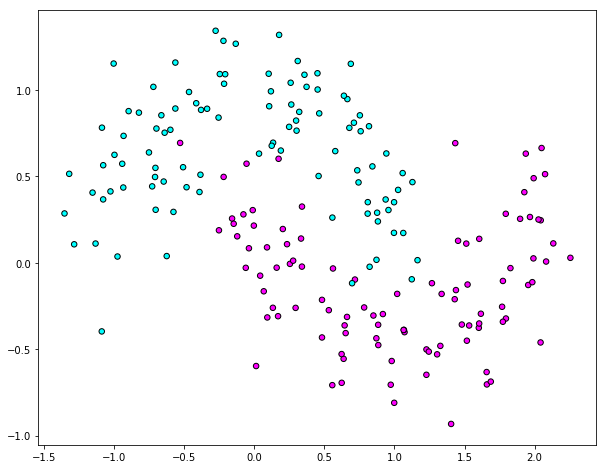

In [18]:
# Generate Dataset
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=.2)
plt.scatter(X[:,0], X[:,1], s = 30, c = y, cmap='cool', edgecolors='black');

### Attempt Using Logistic Regression

In [3]:
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

##### Define Plotting Function

In [4]:
def plotDecisionBoundary(hypothesisFunction):
    
        xmin, xmax = X[:, 0].min() - .5, X[:, 0].max() + .5
        ymin, ymax = X[:, 1].min() - .5, X[:, 1].max() + .5
        h = 0.01
        
        xx, yy = np.meshgrid(np.arange(xmin, xmax, h), np.arange(ymin, ymax, h))

        # Calculate hypothesis over entire grid
        Z = hypothesisFunction(np.c_[xx.ravel(), yy.ravel()])
        
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap='Spectral_r')
        plt.scatter(X[:, 0], X[:, 1], c = y, s=30, edgecolors='black', cmap = 'cool')

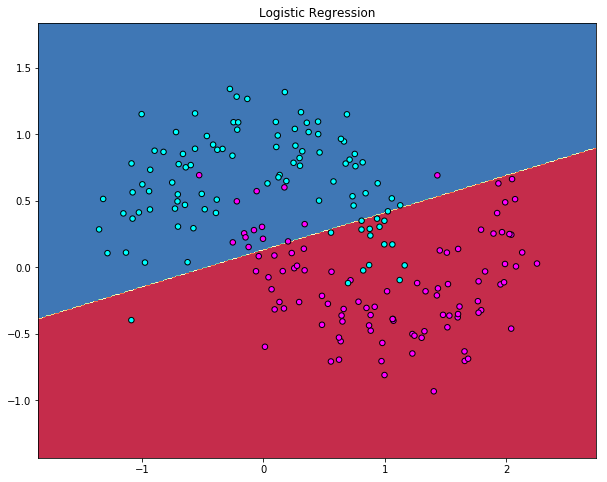

In [5]:
plotDecisionBoundary(lambda x: clf.predict(x))
plt.title("Logistic Regression");

### Attempt Using 3-Layer Feed-Forward NN

We will use the  $tanh$  activation function for the hidden layer, and softmax for the output.

Because we are using softmax:

$$
\begin{aligned}
\sigma (\mathbf {z} )_{j}={\frac {e^{z_{j}}}{\sum _{k=1}^{K}e^{z_{k}}}}
\end{aligned}
$$

We choose cross-entropy loss / negative log likelihood cost function:

$$
\begin{aligned}
L(y,\hat{y}) = - \frac{1}{N} \sum_{n \in N} \sum_{i \in C} y_{n,i} \log\hat{y}_{n,i}
\end{aligned}
$$

Using backpropogation, we calculate the gradients:

$$
\begin{aligned}
& \delta_3 = \hat{y} - y \\
& \delta_2 = (1 - \tanh^2z_1) \circ \delta_3W_2^T \\
& \frac{\partial{L}}{\partial{W_2}} = a_1^T \delta_3  \\
& \frac{\partial{L}}{\partial{b_2}} = \delta_3\\
& \frac{\partial{L}}{\partial{W_1}} = x^T \delta_2\\
& \frac{\partial{L}}{\partial{b_1}} = \delta_2 \\
\end{aligned}
$$

##### Global Variables

In [6]:
num_examples = len(X)
input_dim = output_dim = 2

alpha = .01 # Learning Rate
rlambda = .01 # Regularization Parameter

##### Define Cost Function - Cross-Entropy Loss

In [7]:
def cost(parameters):
    W1, W2, b1, b2 = parameters['W1'], parameters['W2'], parameters['b1'], parameters['b2']
    
    # Forward Prop
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = np.exp(z2)
    
    # Softmax
    probs = a2 / np.sum(a2, axis=1, keepdims=True) 
    
    # Calculate Cost
    logprobs = - np.log(probs[range(num_examples), y])
    loss = np.sum(logprobs)
    
    # Add Regularization
    loss += rlambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    
    return 1/num_examples * loss
    

##### Define Function to Make Predictions, Given Learned Parameters

In [24]:
def makePrediction(parameters, x):
    W1, W2, b1, b2 = parameters['W1'], parameters['W2'], parameters['b1'], parameters['b2']
    # Forward Prop
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    a2 = np.exp(z2)
    
    # Softmax
    probs = a2 / np.sum(a2, axis=1, keepdims=True)
    print(np.argmax(probs, axis=1))
    return np.argmax(probs, axis = 1)

##### Neural Network Model - Learns Optimal Parameters

In [15]:
def build_model(hidden_dim, passes=20000, print_cost=False):
    
    # Initialize Parameters
    np.random.seed(0)
    W1 = np.random.randn(input_dim, hidden_dim)
    b1 = np.zeros((1, hidden_dim))
    W2 = np.random.randn(hidden_dim, output_dim)
    b2 = np.zeros((1, output_dim))

    # Gradient descent. For each batch...
    for i in range(0, passes):

        # Forward Prop
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        a2 = np.exp(z2)
        probs = a2 / np.sum(a2, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += rlambda * W2
        dW1 += rlambda * W1

        # Gradient Descent
        W1 += -alpha * dW1
        b1 += -alpha * db1
        W2 += -alpha * dW2
        b2 += -alpha * db2
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_cost and i % 1000 == 0:
            parameters = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
            print("Cost after iteration %05d: %f" %(i, cost(parameters)))
        
    parameters = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
    
    return parameters

Cost after iteration 00000: 0.395787
Cost after iteration 01000: 0.069106
(151208, 2)
[0 0 0 ..., 1 1 1]


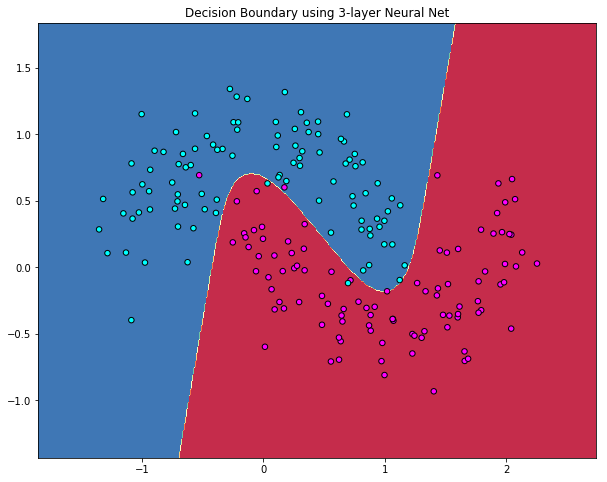

In [25]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, passes=2000, print_cost=True)

# Plot the decision boundary
plotDecisionBoundary(lambda x: makePrediction(model, x))
plt.title("Decision Boundary using 3-layer Neural Net");

In [17]:
# Todo: I don't like how there's two output layers, and a mutliclass loss function.
# I'm thinking we can use a sigmoid fn with 1 output node